# パッケージ


In [5]:
import pandas as pd
import re
import os
from typing import Literal
from tqdm import tqdm
import pickle
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt

# データの整形をするクラス


In [2]:
class HorseProcessor:
    def remove_str(x: any) -> str:
        x_str = str(x)
        is_contain_num = re.search(r"\d+", x_str)
        if is_contain_num:
            return is_contain_num.group()
        else:
            return "0"

    @staticmethod
    def transform_race_length(length: str | int) -> str:
        """距離を変換する

        Args:
            length (str | int): 距離

        Raises:
            TypeError: 型が不正

        Returns:
            str: 変換後の距離
        """
        if isinstance(length, str):
            length = int(length)
        elif math.isnan(length):
            length = 0
        match length:
            case length if length < 1000:
                return "不明"
            case length if length <= 1300:
                return "S"
            case length if length <= 1899:
                return "M"
            case length if length <= 2100:
                return "I"
            case length if length <= 2700:
                return "L"
            case length if length > 2700:
                return "E"

    @staticmethod
    def transform_held(held: str | int) -> str:
        """開催地を変換する

        Args:
            held (str | int): 開催地

        Returns:
            str: 変換後の開催地
        """
        if isinstance(held, int):
            held = str(held)
        trim_held = re.sub(r"\d*", "", held)
        if not trim_held in [
            "東京",
            "中山",
            "中京",
            "阪神",
            "札幌",
            "函館",
            "福島",
            "新潟",
            "京都",
            "小倉",
        ]:
            return "その他"
        return trim_held

    @staticmethod
    def transform_race_name(race: str | int) -> str:
        """レース名を変換する

        Args:
            race (str | int): レース名

        Returns:
            str: 変換後のレース名
        """
        # r"新馬|未勝利|1勝|2勝|3勝|オープン"
        if isinstance(race, int):
            race = str(race)
        if re.search(r".*(新馬|未勝利|1勝|2勝|3勝|OP|G1|G2|G3|L).*", race):
            transform_name = re.sub(
                r".*(新馬|未勝利|1勝|2勝|3勝|OP|G1|G2|G3|L).*", r"\1", race
            )
        else:
            transform_name = "その他"
        return transform_name

    @staticmethod
    def extract_addition(df: pd.DataFrame) -> pd.DataFrame:
        """体重の増減を抽出する

        Args:
            df (pd.DataFrame): 変化対象のデータ

        Returns:
            pd.DataFrame: 変換後のデータ
        """
        weight = df["馬体重"]
        addition = weight.map(lambda x: re.sub(r".*\(([+-]\d{1,3}|0)\).*", r"\1", x))
        addition = addition.map(lambda x: re.sub(r"\+", "", x))
        return addition

    @staticmethod
    def drop_columns(df: pd.DataFrame) -> pd.DataFrame:
        """不要なカラムを削除

        Args:
            df (pd.DataFrame): 成績データ

        Returns:
            pd.DataFrame: 削除後データ
        """
        df_processed = df[["開催", "天気", "レース名", "着順", "距離", "馬場"]]
        return df_processed

    @staticmethod
    def divide_corse(df: pd.DataFrame) -> pd.DataFrame:
        """コースの種類と距離を分ける

        Args:
            df (pd.DataFrame): 加工前データ

        Returns:
            pd.DataFrame: 加工後データ
        """
        df_divided = df
        df_divided["コース"] = df_divided["距離"].map(
            lambda x: x[0] if not isinstance(x, int) else 0
        )
        df_divided["距離"] = df_divided["距離"].map(
            lambda x: x[1:] if not isinstance(x, int) else 0
        )
        return df_divided

    @staticmethod
    def delete_invalid_race(df: pd.DataFrame) -> pd.DataFrame:
        """失格や中止になったレースを削除する

        Args:
            df (pd.DataFrame): 加工前データ

        Returns:
            pd.DataFrame: 加工後データ
        """
        df = df.drop(index=df[df["着順"] == 0].index)
        df = df.drop(index=df[df["着順"] == "0"].index)
        return df

    @classmethod
    def process(cls, path: pd.DataFrame | str):
        """データを整形する

        Args:
            path (pd.DataFrame | str): データのパス

        Returns:
            pd.DataFrame: 整形後データ
        """
        if isinstance(path, str):
            df_raw = pd.read_pickle(path)
        elif isinstance(path, pd.DataFrame):
            df_raw = path
        # 欠損値を0埋め
        df_processed = df_raw.fillna(0)
        # カラム名の空白を削除
        df_processed.columns = df_processed.columns.str.replace(" ", "")

        df_processed = cls.drop_columns(df_processed)
        df_processed["開催"] = df_processed["開催"].map(cls.transform_held)
        df_processed["レース名"] = df_processed["レース名"].map(cls.transform_race_name)
        df_processed = cls.divide_corse(df_processed)
        df_processed["距離"] = df_processed["距離"].map(cls.transform_race_length)
        df_processed["着順"] = df_processed["着順"].map(cls.remove_str)
        df_processed = cls.delete_invalid_race(df_processed)
        df_processed = df_processed.replace(0, "不明")
        return df_processed.iloc[::-1].reset_index(drop=True)

In [3]:
with open("../Raw-Data/Pedigree/2011101125.pickle", "rb") as f:
    test = pickle.load(f)

test_df = pd.DataFrame()
for i in test:
    father_df = pd.read_pickle(f"../Raw-Data/Pedigree-Results/{i}.pkl")
    test = HorseProcessor.process(father_df)
    test_df = pd.concat([test_df, test])
test_df.reset_index(drop=True)

,開催,天気,レース名,着順,距離,馬場,コース
0,阪神,晴,新馬,3,I,良,芝
1,阪神,晴,新馬,16,I,良,芝
2,阪神,晴,未勝利,2,I,稍,芝
3,京都,晴,未勝利,2,L,良,芝
4,東京,晴,未勝利,1,L,良,芝
...,...,...,...,...,...,...,...
58,中山,曇,G1,1,L,稍,芝
59,阪神,晴,G1,5,L,良,芝
60,東京,晴,G1,1,I,良,芝
61,東京,曇,G1,3,L,重,芝


In [4]:
test = pd.read_pickle(f"../Raw-Data/Pedigree-Results/1977103827.pkl")
test = HorseProcessor.process(test)
test

,開催,天気,レース名,着順,距離,馬場,コース
0,東京,晴,OP,3,E,良,芝
1,東京,晴,OP,6,L,良,芝
2,中山,晴,OP,3,L,良,芝


In [3]:
dir_list = os.listdir("../Raw-Data/Pedigree/")
df_integrated = pd.DataFrame()
for i in tqdm(dir_list):
    with open(f"../Raw-Data/Pedigree/{i}", "rb") as f:
        peds = pickle.load(f)
        for ped in peds:
            try:
                df = pd.read_pickle(f"../Raw-Data/Pedigree-Results/{ped}.pkl")
                df = HorseProcessor.process(df)
                df_integrated = pd.concat([df_integrated, df])
                df_integrated = df_integrated.reset_index(drop=True)
            except Exception as e:
                print(ped)
                raise Exception(e)

  0%|          | 0/11557 [00:00<?, ?it/s]

100%|██████████| 11557/11557 [17:07<00:00, 11.25it/s]


In [18]:
print(df_integrated["開催"].unique())
print(df_integrated["天気"].unique())
print(df_integrated["レース名"].unique())
print(df_integrated["着順"].unique())
print(df_integrated["距離"].unique())
print(df_integrated["馬場"].unique())
print(df_integrated["コース"].unique())
df_integrated.to_csv("../tmp/peds-results.csv")
df_integrated.to_pickle("../tmp/peds-results.pkl")
df_integrated

['京都' '阪神' '中山' '東京' '中京' '札幌' 'その他' '新潟' '小倉' '函館' '福島']
['曇' '晴' '雨' '不明' '小雨' '雪' '小雪']
['新馬' '未勝利' 'その他' 'G3' 'G1' 'G2' 'OP' 'L']
['2' '4' '1' '3' '5' '16' '8' '10' '7' '6' '12' '13' '11' '15' '9' '17'
 '14' '18' '19' '20']
['M' 'I' 'L' 'E' 'S' '不明']
['良' '稍' '重' '不' '不明']
['芝' 'ダ' '不明' '障']


,開催,天気,レース名,着順,距離,馬場,コース
0,京都,曇,新馬,2,M,良,芝
1,京都,晴,未勝利,4,M,良,ダ
2,京都,晴,未勝利,1,M,良,ダ
3,阪神,曇,その他,1,I,稍,芝
4,阪神,曇,G3,1,I,良,芝
...,...,...,...,...,...,...,...
288312,その他,不明,G1,1,M,稍,芝
288313,その他,不明,G1,1,M,良,芝
288314,その他,不明,G1,1,I,良,芝
288315,その他,不明,G1,1,I,重,芝


# テンプレート作成


In [16]:
place = [
    "札幌",
    "函館",
    "福島",
    "新潟",
    "中山",
    "東京",
    "中京",
    "京都",
    "阪神",
    "小倉",
    "その他",
]
race = ["重賞", "非重賞"]
length = ["S", "M", "I", "L", "E"]
state = ["良", "稍", "重", "不"]
seed = ["芝", "ダ", "障"]
win = ["1", "2", "3", "3<"]
columns = []
for p in place:
    for r in race:
        for l in length:
            for s in seed:
                for se in state:
                    for wi in win:
                        columns.append(f"{p}_{r}_{l}_{s}_{se}_{wi}")

columns = [i for i in columns if not re.match(r"札幌_重賞_L.*", i)]
columns = [i for i in columns if not re.match(r"札幌_重賞_(S|I)_ダ.*", i)]
columns = [i for i in columns if not re.match(r"札幌_非重賞_L_ダ.*", i)]
columns = [i for i in columns if not re.match(r"札幌_非*重賞_(S|M|I|L)_障.*", i)]
columns = [i for i in columns if not re.match(r"札幌_非*重賞_E.*", i)]

columns = [i for i in columns if not re.match(r"函館_重賞_[SI]_ダ.*", i)]
columns = [i for i in columns if not re.match(r"函館_重賞_[LE].*", i)]
columns = [i for i in columns if not re.match(r"函館_非重賞_[IL]_ダ.*", i)]
columns = [i for i in columns if not re.match(r"函館_非重賞_E.*", i)]
columns = [i for i in columns if not re.match(r"函館_非*重賞_._障.*", i)]

columns = [i for i in columns if not re.match(r"福島_重賞_(S|L|E).*", i)]
columns = [i for i in columns if not re.match(r"福島_重賞_(M|I)_[ダ障].*", i)]
columns = [i for i in columns if not re.match(r"福島_重賞_._障.*", i)]
columns = [i for i in columns if not re.match(r"福島_非重賞_(I|L)_ダ.*", i)]
columns = [i for i in columns if not re.match(r"福島_非重賞_[SMIL]_障.*", i)]
columns = [i for i in columns if not re.match(r"福島_非重賞_E_[芝ダ].*", i)]

columns = [i for i in columns if not re.match(r"新潟_重賞_S_[ダ].*", i)]
columns = [i for i in columns if not re.match(r"新潟_重賞_[SMIL]_障.*", i)]
columns = [i for i in columns if not re.match(r"新潟_非*重賞_[IL]_ダ.*", i)]
columns = [i for i in columns if not re.match(r"新潟_非*重賞_E_[芝ダ].*", i)]
columns = [i for i in columns if not re.match(r"新潟_非重賞_[SMIL]_障.*", i)]

columns = [i for i in columns if not re.match(r"中山_重賞_[ILE]_ダ.*", i)]
columns = [i for i in columns if not re.match(r"中山_重賞_[SMIL]_障.*", i)]
columns = [i for i in columns if not re.match(r"中山_非重賞_[IE]_ダ.*", i)]
columns = [i for i in columns if not re.match(r"中山_非重賞_[E]_芝.*", i)]
columns = [i for i in columns if not re.match(r"中山_非重賞_[SMI]_障.*", i)]

columns = [i for i in columns if not re.match(r"東京_非*重賞_[SMIL]_障.*", i)]
columns = [i for i in columns if not re.match(r"東京_非*重賞_S_芝.*", i)]
columns = [i for i in columns if not re.match(r"東京_重賞_[LE]_ダ.*", i)]
columns = [i for i in columns if not re.match(r"東京_非重賞_[E]_ダ.*", i)]

columns = [i for i in columns if not re.match(r"中京_重賞_._障.*", i)]
columns = [i for i in columns if not re.match(r"中京_重賞_[SIE]_ダ.*", i)]
columns = [i for i in columns if not re.match(r"中京_重賞_[L]_芝.*", i)]
columns = [i for i in columns if not re.match(r"中京_非重賞_[IE]_ダ.*", i)]
columns = [i for i in columns if not re.match(r"中京_非重賞_E_芝.*", i)]
columns = [i for i in columns if not re.match(r"中京_非重賞_[SMIL]_障.*", i)]

columns = [i for i in columns if not re.match(r"京都_非*重賞_[LE]_ダ.*", i)]
columns = [i for i in columns if not re.match(r"京都_非*重賞_[SMIL]_障.*", i)]

columns = [i for i in columns if not re.match(r"阪神_重賞_[SLE]_ダ.*", i)]
columns = [i for i in columns if not re.match(r"阪神_重賞_[SMIL]_障.*", i)]
columns = [i for i in columns if not re.match(r"阪神_非重賞_[SMIL]_障.*", i)]
columns = [i for i in columns if not re.match(r"阪神_非重賞_L_ダ.*", i)]
columns = [i for i in columns if not re.match(r"阪神_非重賞_E_[ダ芝].*", i)]

columns = [i for i in columns if not re.match(r"小倉_重賞_[SMI]_[ダ障].*", i)]
columns = [i for i in columns if not re.match(r"小倉_重賞_L_[芝障].*", i)]
columns = [i for i in columns if not re.match(r"小倉_重賞_E_[芝ダ].*", i)]
columns = [i for i in columns if not re.match(r"小倉_非重賞_[SMIL]_障.*", i)]
columns = [i for i in columns if not re.match(r"小倉_非重賞_[IL]_ダ.*", i)]
columns = [i for i in columns if not re.match(r"小倉_非重賞_E_[ダ芝].*", i)]

columns = [i for i in columns if not re.match(r"その他_非*重賞_._障.*", i)]
df_tmp = pd.DataFrame(columns=columns, index=[0]).fillna(0)
df_tmp

,札幌_重賞_S_芝_良_1,札幌_重賞_S_芝_良_2,札幌_重賞_S_芝_良_3,札幌_重賞_S_芝_良_3<,札幌_重賞_S_芝_稍_1,札幌_重賞_S_芝_稍_2,札幌_重賞_S_芝_稍_3,札幌_重賞_S_芝_稍_3<,札幌_重賞_S_芝_重_1,札幌_重賞_S_芝_重_2,...,その他_非重賞_E_ダ_稍_3,その他_非重賞_E_ダ_稍_3<,その他_非重賞_E_ダ_重_1,その他_非重賞_E_ダ_重_2,その他_非重賞_E_ダ_重_3,その他_非重賞_E_ダ_重_3<,その他_非重賞_E_ダ_不_1,その他_非重賞_E_ダ_不_2,その他_非重賞_E_ダ_不_3,その他_非重賞_E_ダ_不_3<
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df = pd.read_pickle("../tmp/peds-results.pkl")
race = ["G3", "G1", "G2"]
for index, row in df.iterrows():
    col = [row["距離"], row["コース"]]
    if "不明" in col:
        continue
    w = row["着順"] if int(row["着順"]) <= 3 else "3<"
    s = row["馬場"] if row["馬場"] != "不明" else "良"
    r = "重賞" if row["レース名"] in race else "非重賞"
    col = f'{row["開催"]}_{r}_{row["距離"]}_{row["コース"]}_{s}_{w}'
    df_tmp[col] += 1

In [ ]:
for i in df_tmp:
    tex = df_tmp[i][0]
    if tex == 0:
        if not re.search(r"(札幌|函館|福島|新潟|中山|東京|中京|京都|阪神|小倉).*", i):
            if not re.search(r"その他_非重賞_E.*", i):
                print(i)
df_tmp

In [17]:
df_tmp.to_pickle("../template/pedigree_results_template.pkl")

# 次元圧縮モデル作成


## 父と母父の成績を集計するクラス


In [2]:
class PedigreeProcessor:
    race_class = ["G3", "G1", "G2"]

    def remove_str(x: any) -> str:
        """文字列の数字のみを抽出する

        Args:
            x (any): 文字列に変換できる値

        Returns:
            str: 抽出した数字（文字列）
        """
        x_str: str = str(x)
        is_contain_num: re.Match | None = re.search(r"\d+", x_str)
        if is_contain_num:
            return is_contain_num.group()
        else:
            return "0"

    @staticmethod
    def transform_race_length(
        length: str | int,
    ) -> Literal["S", "M", "I", "L", "E", "不明"]:
        """コースの距離をSMILE区分に変換する

        Args:
            length (str | int):数字のみで構成された文字列または整数

        Raises:
            TypeError: 文字でも整数でもない値が入った場合はエラー

        Returns:
            str: 「S」「M」「I」「L」「E」のいずれかの文字または「不明」
        """
        if isinstance(length, str):
            # 距離の記載がない場合に対応
            if re.match(r"\d+", length):
                length: int = int(length)
            else:
                length: int = 0
        elif math.isnan(length):
            length: int = 0
        elif not isinstance(length, int):
            raise TypeError(
                f'"length" argument is expected to be of type int or str, got {type(length).__name__} instead. The value is {length}'
            )
        match length:
            case length if length < 1000:
                return "不明"
            case length if length <= 1300:
                return "S"
            case length if length <= 1899:
                return "M"
            case length if length <= 2100:
                return "I"
            case length if length <= 2700:
                return "L"
            case length if length > 2700:
                return "E"

    @staticmethod
    def transform_held(
        held: str | int,
    ) -> Literal[
        "東京",
        "中山",
        "中京",
        "阪神",
        "札幌",
        "函館",
        "福島",
        "新潟",
        "京都",
        "小倉",
        "不明",
    ]:
        """「競馬場名＋開催日」の書式の文字列から競馬場名を抽出する。中央の競馬場以外は「その他」に変換

        Args:
            held (str | int): 「競馬場名＋開催日」の書式の文字列

        Returns:
            str: 中央の競馬場名または「不明」
        """
        # 数値だった場合に文字列に変換する
        if isinstance(held, int):
            held: str = str(held)
        trim_held: str = re.sub(r"\d*", "", held)
        if not trim_held in [
            "東京",
            "中山",
            "中京",
            "阪神",
            "札幌",
            "函館",
            "福島",
            "新潟",
            "京都",
            "小倉",
        ]:
            return "その他"
        return trim_held

    @staticmethod
    def transform_race_name(
        race: str | int,
    ) -> Literal[
        "新馬", "未勝利", "1勝", "2勝", "3勝", "OP", "G1", "G2", "G3", "L", "不明"
    ]:
        """レースのクラスを分類する

        Args:
            race (str | int): レースのクラス

        Returns:
            str: クラス名もしくは「不明」
        """
        if isinstance(race, int):
            race = str(race)
        if re.search(r".*(新馬|未勝利|1勝|2勝|3勝|OP|G1|G2|G3|L).*", race):
            transform_name = re.sub(
                r".*(新馬|未勝利|1勝|2勝|3勝|OP|G1|G2|G3|L).*", r"\1", race
            )
        else:
            transform_name = "その他"
        return transform_name

    @staticmethod
    def drop_columns(df: pd.DataFrame) -> pd.DataFrame:
        """不要なカラムを削除

        Args:
            df (pd.DataFrame): 成績データ

        Returns:
            pd.DataFrame: 削除後データ
        """
        df_processed: pd.DataFrame = df[
            ["開催", "天気", "レース名", "着順", "距離", "馬場"]
        ]
        return df_processed

    @staticmethod
    def divide_corse(df: pd.DataFrame) -> pd.DataFrame:
        """データフレーム内の「距離」の値をコースと距離に分ける。それぞれの値は「コース」「距離」の値で入る

        Args:
            df (pd.DataFrame): 加工前の成績データ

        Returns:
            pd.DataFrame: 加工後のデータフレーム
        """
        df_divided: pd.DataFrame = df.copy()
        df_divided["コース"] = df_divided["距離"].map(
            lambda x: x[0] if not isinstance(x, int) else 0
        )
        df_divided["距離"] = df_divided["距離"].map(
            lambda x: x[1:] if not isinstance(x, int) else 0
        )
        return df_divided

    @staticmethod
    def delete_invalid_race(df: pd.DataFrame) -> pd.DataFrame:
        """着順が0となっているものは失格や中止のため除外する

        Args:
            df (pd.DataFrame): 除外前の成績データ

        Returns:
            pd.DataFrame: 除外後の成績データ
        """
        df: pd.DataFrame = df.drop(index=df[df["着順"] == 0].index)
        df = df.drop(index=df[df["着順"] == "0"].index)
        return df

    @staticmethod
    def preprocessing(df: pd.DataFrame) -> pd.DataFrame:
        """成績データの0埋めと不要な空白の削除を行う

        Args:
            df (pd.DataFrame): 変換前の成績データ

        Returns:
            pd.DataFrame: 変換後の成績データ
        """
        # 欠損値を0埋め
        df_preprocessed: pd.DataFrame = df.fillna(0)
        # カラム名の空白を削除
        df_preprocessed.columns = df_preprocessed.columns.str.replace(" ", "")
        return df_preprocessed

    @classmethod
    def totalling_pedigree_result(cls, df: pd.DataFrame) -> pd.DataFrame:
        """成績データを競馬場や馬場、着順等で分けて集計する

        Args:
            df (pd.DataFrame): 成績データ（時系列順）

        Returns:
            pd.DataFrame: 集計した成績データ
        """
        df_tmp: pd.DataFrame = pd.read_pickle(
            "../template/pedigree_results_template.pkl"
        )
        for index, row in df.iterrows():
            col: list[str] = [row["距離"], row["コース"]]
            if "不明" in col:
                continue
            rank: str = row["着順"] if int(row["着順"]) <= 3 else "3<"
            state: str = row["馬場"] if row["馬場"] != "不明" else "良"
            race_type: str = "重賞" if row["レース名"] in cls.race_class else "非重賞"
            col = f'{row["開催"]}_{race_type}_{row["距離"]}_{row["コース"]}_{state}_{rank}'
            df_tmp[col] += 1
        return df_tmp

    @classmethod
    def transform_data(cls, df_raw: pd.DataFrame) -> pd.DataFrame:
        """成績データの内容を集計出来る形に変換する

        Args:
            df_raw (pd.DataFrame):変換前データ

        Returns:
            pd.DataFrame: 変換誤データ
        """
        df = df_raw.copy()
        df_transformed = cls.drop_columns(df)
        df_transformed = cls.divide_corse(df_transformed)
        df_transformed["開催"] = df_transformed["開催"].map(cls.transform_held)
        df_transformed["レース名"] = df_transformed["レース名"].map(
            cls.transform_race_name
        )
        df_transformed["距離"] = df_transformed["距離"].map(cls.transform_race_length)
        df_transformed["着順"] = df_transformed["着順"].map(cls.remove_str)
        df_transformed = cls.delete_invalid_race(df_transformed)
        df_transformed = df_transformed.replace(0, "不明")
        return df_transformed

    @classmethod
    def transform_pedigree_results(cls, path: pd.DataFrame | str) -> pd.DataFrame:
        """成績データに関する処理を統合した関数

        Args:
            path (pd.DataFrame | str):未加工の成績データ

        Raises:
            TypeError: データフレームもしくはそれの場所を示す文字列出なかった場合はエラー

        Returns:
            pd.DataFrame: 加工後のデータ
        """
        if isinstance(path, str):
            df_raw: pd.DataFrame = pd.read_pickle(path)
        elif isinstance(path, pd.DataFrame):
            df_raw = path
        else:
            raise TypeError(
                f'"path" argument is expected to be of type pd.DataFrame or str, got {type(path).__name__} instead'
            )
        # 前処理
        df_processed: pd.DataFrame = cls.preprocessing(df_raw)
        # 変換
        df_processed = cls.transform_data(df_processed)
        return df_processed.iloc[::-1].reset_index(drop=True)

    @classmethod
    def process_pedigree_results(cls, path1: str, path2: str) -> pd.DataFrame:
        """関数を統合して、父と母父の成績データを変換して集計する一つの関数とした

        Args:
            path1 (str): 父の成績データ
            path2 (str): 母父の成績データ

        Returns:
            pd.DataFrame: 統合データ
        """
        df1_transformed = cls.transform_pedigree_results(path1)
        df2_transformed = cls.transform_pedigree_results(path2)
        df1_processed = cls.totalling_pedigree_result(df1_transformed)
        df2_processed = cls.totalling_pedigree_result(df2_transformed)
        return pd.concat([df1_processed, df2_processed], axis=1)

In [3]:
test_peds = pd.read_pickle("../Raw-Data/Pedigree/2011100643.pickle")
ped1 = f"../Raw-Data/Pedigree-Results/{test_peds[0]}.pkl"
ped2 = f"../Raw-Data/Pedigree-Results/{test_peds[1]}.pkl"
PedigreeProcessor.process_pedigree_results(ped1, ped2)

,札幌_重賞_S_芝_良_1,札幌_重賞_S_芝_良_2,札幌_重賞_S_芝_良_3,札幌_重賞_S_芝_良_3<,札幌_重賞_S_芝_稍_1,札幌_重賞_S_芝_稍_2,札幌_重賞_S_芝_稍_3,札幌_重賞_S_芝_稍_3<,札幌_重賞_S_芝_重_1,札幌_重賞_S_芝_重_2,...,その他_非重賞_E_ダ_稍_3,その他_非重賞_E_ダ_稍_3<,その他_非重賞_E_ダ_重_1,その他_非重賞_E_ダ_重_2,その他_非重賞_E_ダ_重_3,その他_非重賞_E_ダ_重_3<,その他_非重賞_E_ダ_不_1,その他_非重賞_E_ダ_不_2,その他_非重賞_E_ダ_不_3,その他_非重賞_E_ダ_不_3<
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 保存しているデータから集計データを作成


In [4]:
dir_list = os.listdir("../Raw-Data/Pedigree/")
dfs = []
for i in tqdm(dir_list):
    peds = pd.read_pickle(f"../Raw-Data/Pedigree/{i}")
    ped1 = f"../Raw-Data/Pedigree-Results/{peds[0]}.pkl"
    ped2 = f"../Raw-Data/Pedigree-Results/{peds[1]}.pkl"
    result = PedigreeProcessor.process_pedigree_results(ped1, ped2)
    dfs.append(result)
df_integrated = pd.concat(dfs)
df_integrated

100%|██████████| 49160/49160 [3:20:56<00:00,  4.08it/s]  


,札幌_重賞_S_芝_良_1,札幌_重賞_S_芝_良_2,札幌_重賞_S_芝_良_3,札幌_重賞_S_芝_良_3<,札幌_重賞_S_芝_稍_1,札幌_重賞_S_芝_稍_2,札幌_重賞_S_芝_稍_3,札幌_重賞_S_芝_稍_3<,札幌_重賞_S_芝_重_1,札幌_重賞_S_芝_重_2,...,その他_非重賞_E_ダ_稍_3,その他_非重賞_E_ダ_稍_3<,その他_非重賞_E_ダ_重_1,その他_非重賞_E_ダ_重_2,その他_非重賞_E_ダ_重_3,その他_非重賞_E_ダ_重_3<,その他_非重賞_E_ダ_不_1,その他_非重賞_E_ダ_不_2,その他_非重賞_E_ダ_不_3,その他_非重賞_E_ダ_不_3<
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
dir_list = os.listdir("../Raw-Data/Pedigree/")
peds = pd.read_pickle(f"../Raw-Data/Pedigree/{dir_list[46372]}")
ped1 = f"../Raw-Data/Pedigree-Results/{peds[0]}.pkl"
ped2 = f"../Raw-Data/Pedigree-Results/{peds[1]}.pkl"
test = PedigreeProcessor.preprocessing(pd.read_pickle(ped2))
PedigreeProcessor.transform_data(test)
# result = PedigreeProcessor.process_pedigree_results(ped1, ped2)

2000
----

----
2050
----
2000
----
1800
----
2000
----
1600
----
1600
----
2000
----
2100
----
2000
----
2000
----
2400
----
2400
----
2400
----
2100
----


,開催,天気,レース名,着順,距離,馬場,コース
0,その他,不明,G1,3,I,良,ダ
1,その他,不明,OP,1,不明,良,ダ
2,その他,不明,G1,7,I,良,芝
3,その他,不明,G1,7,I,良,芝
4,その他,不明,G1,2,M,良,芝
5,その他,晴,G1,3,I,良,ダ
6,その他,不明,G1,8,M,重,芝
7,その他,不明,G1,5,M,稍,芝
8,その他,不明,G1,4,I,良,芝
9,その他,不明,G1,1,I,良,芝


In [5]:
df_integrated = pd.concat(dfs)
df_integrated

,札幌_重賞_S_芝_良_1,札幌_重賞_S_芝_良_2,札幌_重賞_S_芝_良_3,札幌_重賞_S_芝_良_3<,札幌_重賞_S_芝_稍_1,札幌_重賞_S_芝_稍_2,札幌_重賞_S_芝_稍_3,札幌_重賞_S_芝_稍_3<,札幌_重賞_S_芝_重_1,札幌_重賞_S_芝_重_2,...,その他_非重賞_E_芝_稍_3,その他_非重賞_E_芝_稍_3<,その他_非重賞_E_芝_重_1,その他_非重賞_E_芝_重_2,その他_非重賞_E_芝_重_3,その他_非重賞_E_芝_重_3<,その他_非重賞_E_芝_不_1,その他_非重賞_E_芝_不_2,その他_非重賞_E_芝_不_3,その他_非重賞_E_芝_不_3<
0,22,0,242,133,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,22,0,242,133,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,22,0,242,133,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,22,0,242,133,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,22,0,242,133,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,22,0,242,133,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,22,0,242,133,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,22,0,242,133,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,22,0,242,133,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df_integrated.to_pickle("../tmp/pedigree-results-list.pkl")
df_integrated.to_csv("../tmp/pedigree-results-list.csv")

## NNのAE


### AE

In [10]:
class AutoEncoder(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        latent_dim: int,
        num_layers: int,
        dropout: float,
    ):
        """
        自己符号化器の初期化

        Args:
            input_dim (int): 入力データの次元数
            hidden_dim (int): 各中間層のニューロン数
            latent_dim (int): 圧縮後の次元数(潜在空間の次元数)
            num_layers (int): 中間層の数
            dropout (float): ドロップアウト率
        """
        super().__init__()

        # エンコーダー部分の構築
        encoder_layers = []
        prev_dim = input_dim
        for _ in range(num_layers):
            encoder_layers.extend(
                [
                    nn.Linear(prev_dim, hidden_dim),
                    nn.BatchNorm1d(hidden_dim),
                    nn.Mish(),
                    nn.Dropout(dropout),
                ]
            )
            prev_dim = hidden_dim
        encoder_layers.append(nn.Linear(prev_dim, latent_dim))
        self.encoder = nn.Sequential(*encoder_layers)

        # デコーダー部分の構築
        decoder_layers = []
        prev_dim = latent_dim
        for _ in range(num_layers):
            decoder_layers.extend(
                [
                    nn.Linear(prev_dim, hidden_dim),
                    nn.BatchNorm1d(hidden_dim),
                    nn.Mish(),
                    nn.Dropout(dropout),
                ]
            )
            prev_dim = hidden_dim
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        順伝播
        Args:
            x (torch.Tensor): 入力データ
        Returns:
            tuple[torch.Tensor, torch.Tensor]: (圧縮後のデータ, 再構成後のデータ)
        """
        encoded = self.encoder(x)  # エンコード
        decoded = self.decoder(encoded)  # デコード
        return encoded, decoded

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """
        エンコードのみを行う
        Args:
            x (torch.Tensor): 入力データ
        Returns:
            torch.Tensor: 圧縮後のデータ
        """
        return self.encoder(x)

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """
        デコードのみを行う
        Args:
            z (torch.Tensor): 圧縮されたデータ
        Returns:
            torch.Tensor: 再構成後のデータ
        """
        return self.decoder(z)

### 損失関数

In [11]:
def ae_loss(recon_x, x):
    """AutoEncoderの損失関数
    Args:
        recon_x: 再構成されたデータ
        x: 入力データ
    Returns:
        reconstruction_loss: 再構成誤差
    """
    reconstruction_loss = F.mse_loss(recon_x, x, reduction="sum")
    return reconstruction_loss

In [12]:
class PedigreeDataset(Dataset):
    def __init__(self, df):
        # DataFrameを直接受け取る
        self.df = df.astype("float32")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        data_tensor = torch.tensor(row.values, dtype=torch.float32)
        return data_tensor

### optunaのパラメータ最適化

In [20]:
# ファイルの読み込み
file_path = "../tmp/pedigree-results-list.pkl"
df = pd.read_pickle(file_path)

# データの分割
train_df, test_df = train_test_split(df, test_size=0.3)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# データセットの作成
train_dataset = PedigreeDataset(train_df)
val_dataset = PedigreeDataset(val_df)
test_dataset = PedigreeDataset(test_df)

# データローダーの設定
batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(df.shape)

cuda
(49160, 5024)


In [21]:
def objective(trial):
    # ハイパーパラメータの設定
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    hidden_dim = trial.suggest_int("hidden_dim", 1000, 4000)
    latent_dim = trial.suggest_int("latent_dim", 1000, 4000, log=True)
    num_layers = trial.suggest_int("num_layers", 2, 10)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)

    # モデルとオプティマイザの設定
    model = AutoEncoder(
        input_dim=5024,
        hidden_dim=hidden_dim,
        latent_dim=latent_dim,
        num_layers=num_layers,
        dropout=dropout,
    )
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    # 訓練ループ
    for epoch in range(10):  # エポック数は適宜調整
        model.train()
        for batch in train_loader:
            input_data = batch.to(device)

            optimizer.zero_grad()
            _, recon_batch = model(input_data)
            loss = ae_loss(recon_batch, input_data)
            loss.backward()
            optimizer.step()

    # 検証データセットでの性能評価
    return loss.item()

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1)  # 試行回数は適宜調整

# 最適なハイパーパラメータを取得
best_params = study.best_params
best_value = study.best_trial.value
print("最適なハイパーパラメータ:", best_params)
print("最適な試行の値:", best_value)

バッチサイズ:1024  
最適なハイパーパラメータ: {'lr': 0.0020184536345385614, 'hidden_dim': 1990, 'latent_dim': 1090, 'num_layers': 5, 'dropout': 0.3572507156163663}  
最適な試行の値: 23962.12109375  
最適なハイパーパラメータ: {'lr': 0.00018573010765771052, 'hidden_dim': 3353, 'latent_dim': 1603, 'num_layers': 9, 'dropout': 0.00578880842136098}  
最適な試行の値: 17172.19140625

※バッチサイズ:100  
最適なハイパーパラメータ: {'lr': 0.0005422326782088436, 'hidden_dim': 1580, 'latent_dim': 1427, 'num_layers': 2, 'dropout': 0.09732006046061914}  
最適な試行の値: 163.613525390625

### 本学習

Epoch 0, Train Loss: 110.5884146462594, Val Loss: 31.866154610998112
Epoch 2, Train Loss: 30.9938524345917, Val Loss: 27.887961054409413
Epoch 4, Train Loss: 26.63112677767082, Val Loss: 24.20307959828563
Epoch 6, Train Loss: 23.512787793100003, Val Loss: 21.308449315796164
Epoch 8, Train Loss: 20.41468180430183, Val Loss: 18.18820826674415
Epoch 9, Train Loss: 18.92944081411875, Val Loss: 16.81616987732457


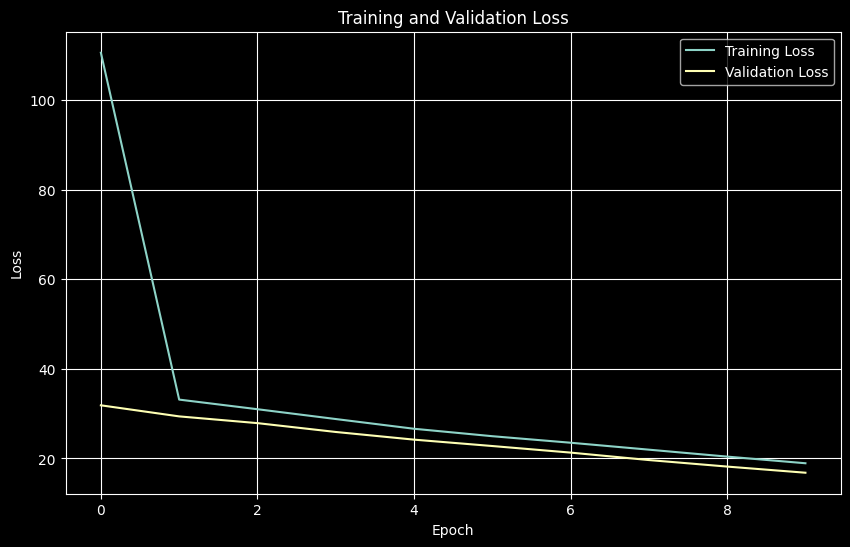

In [13]:
file_path = "../tmp/pedigree-results-list.pkl"
df = pd.read_pickle(file_path)

# データの分割
train_df, test_df = train_test_split(df, test_size=0.3)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# データセットの作成
train_dataset = PedigreeDataset(train_df)
val_dataset = PedigreeDataset(val_df)
test_dataset = PedigreeDataset(test_df)

# データローダーの設定
batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoEncoder(
    input_dim=5024,
    hidden_dim=1580,
    latent_dim=1427,
    num_layers=2,
    dropout=0.09732006046061914,
)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0005422326782088436)

# エポック数
num_epochs = 10
# 評価を行うエポック数
eval_interval = 2

# 誤差を記録するリスト
train_losses = []
val_losses = []

# 訓練ループ
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        input_data = batch.to(device)

        optimizer.zero_grad()
        _, recon_batch = model(input_data)
        loss = ae_loss(recon_batch, input_data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    # エポックごとの平均誤差を計算
    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # 一定のエポック数ごとに検証データセットでモデルを評価
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_batch in val_loader:
            val_input = val_batch.to(device)
            _, recon_batch = model(val_input)
            loss = ae_loss(recon_batch, val_input)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    if epoch % eval_interval == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

# 学習曲線をプロット
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_losses, label="Training Loss")
plt.plot(range(num_epochs), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
model.eval()
test_loss = 0
with torch.no_grad():
    for test_batch in test_loader:
        test_input = test_batch.to(device)
        _, recon_batch = model(test_input)
        loss = ae_loss(recon_batch, test_input)
        test_loss += loss.item()

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss}")

Test Loss: 16.474267862856404


In [15]:
torch.save(model.state_dict(), "../models/v2/pedigree_result_AE.pth")

### 確認

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncoder(
    input_dim=5024,
    hidden_dim=1580,
    latent_dim=1427,
    num_layers=2,
    dropout=0.09732006046061914,
)
model.to(device)

model.load_state_dict(torch.load("../models/v2/pedigree_result_AE.pth"))
model.eval()

file_path = "../tmp/pedigree-results-list.pkl"
df = pd.read_pickle(file_path)
sample = df.sample()

# データフレームをテンソルに変換してGPUに転送
data = torch.tensor(sample.values, dtype=torch.float32).to(device)
# 潜在変数の取得
with torch.no_grad():
    encoded = model.encode(data)

print(f"入力データサイズ: {data.size()}")
print(f"潜在変数サイズ: {encoded.size()}")
print("\n潜在変数:")
print(encoded.cpu().numpy())

入力データサイズ: torch.Size([1, 5024])
潜在変数サイズ: torch.Size([1, 1427])

潜在変数:
[[ 0.24165882 -0.21781567  0.07189621 ...  0.13460793 -0.5051828
  -0.09857646]]
